# Handy
## Process data
Now that you have your frames recorded (if not, see [gathering data](0_Gather_Data.ipynb)), let's process it.

The most effective way I came up with to recognize different "pose gestures" is probably to calculate angles between specific joints, as shown in the figure below.

![Angles](./angles.png)

In [1]:
%pip install opencv-python mediapipe numpy pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
from os import path


if not path.exists("frames/"):
    print("Frames directory not found!")
    exit(-1)

In [3]:
POSES = {
    '0': '0.png',
    '1': '1.png',
    '2': '2.png',
    '3': '3.png',
    '4': '4.png',
    '5': '5.png',
    '6': '6.png',
    '7': '7.png',
    '8': '8.png',
    '9': '9.png',
    '10': '10.png',
    '11': '11.png',
    '12': '12.png',
}


HANDY_WINDOW = "Handy"

In [4]:
import numpy as np

def calculate_angle(a, b, c):
    """
    Calculates the angle ABC given (x, y) of A, B and C 

    Args:
        a (x, y)
        b (x, y)
        c (x, y)

    Returns:
        float: Angle (degrees)
    """
    # Define points
    A = np.array(a)
    B = np.array(b)
    C = np.array(c)

    # Calculate vectors
    BA = A - B
    BC = C - B

    # Calculate the cosine of the angle
    cosine_angle = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC))

    # Calculate the angle and convert it to degrees
    angle = np.arccos(cosine_angle)
    angle_deg = np.degrees(angle)

    return angle_deg

def calculate_angle_from_obj(a, b, c):
    a = (a.x, a.y)  # First
    b = (b.x, b.y)  # Mid - the angle corner
    c = (c.x, c.y)  # End

    return calculate_angle(a, b, c)

def check_similarity(previous_angles: list[float], new_angles: list[float], threshold: int = 5) -> bool:
    """
    To prevent wrong data caused by corrupted frames, check if the angles differ much from the previous ones

    Args:
        previous_angles
        new_angles
        threshold (int, optional): Max difference between previous and current angle. Defaults to 10.

    Returns:
        bool: If false, the angles differ from each other much
    """
    # Check if the lists have the same length
    if len(previous_angles) != len(new_angles):
        return False

    # Zip the items from both the lists and compare them
    for prev, curr in zip(previous_angles, new_angles):
        if abs(prev - curr) > threshold:
            return False  # Difference is greater than the threshold for at least one pair of elements

    return True


In [5]:
from os import path
import time
import cv2
import mediapipe as mp
import numpy as np

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

def handle_frame(frame: cv2.typing.MatLike, holistic, class_name: str, previous_angles: list[float]) -> tuple[list[float], bool]:
    """
        Handle a single frame

    Args:
        frame (cv2.typing.MatLike): The current frame
        holistic
        class_name (str): Current class_name

    Returns:
        tuple[list[float], bool]: A list of angles, whether the angles are similar to the previous ones
    """
    # Recolor Feed
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    # Make Detections
    results = holistic.process(image)

    if results.pose_landmarks is None:
        return (None, False) # It means: no detections

    # Pose Detections
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=1, circle_radius=2),
        mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=1, circle_radius=1),
    )
    if results.pose_landmarks is not None:
        # Calculate the angles
        # See train/angles.png for more info

        landmarks = results.pose_landmarks.landmark

        angles = []
        # Angle 0
        angles.append(
            calculate_angle_from_obj(landmarks[12], landmarks[14], landmarks[16])
        )
        # Angle 1
        angles.append(
            calculate_angle_from_obj(landmarks[11], landmarks[13], landmarks[15])
        )
        # Angle 2
        angles.append(
            calculate_angle_from_obj(landmarks[14], landmarks[12], landmarks[24])
        )
        # Angle 3
        angles.append(
            calculate_angle_from_obj(landmarks[13], landmarks[11], landmarks[23])
        )
        for index, angle in enumerate(angles):
            cv2.putText(image, str(int(angle)), (0, 30 * (index + 1)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 1)

        # Check whether the current angles are similar to the previous ones - to prevent random jumps (e.g. corrupted frame)
        are_similar = True if previous_angles is None else check_similarity(previous_angles, angles)
        if not are_similar:
            cv2.putText(image, str("SKIP!"), (0, (len(angles) + 1) * 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)

    cv2.imshow(HANDY_WINDOW, image)
    return (angles, are_similar)

In [6]:
import os

# Prepare filelist
items = os.listdir("frames/")
items = [item for item in items if item.endswith(".png")]

def custom_sort_key(s):
    parts = s.split("_")
    x = int(parts[0])
    y = int(parts[1].split(".")[0])  # Remove the ".png" extension and convert to int
    return (x, y)
items = sorted(items, key=custom_sort_key)

# Convert the files into dict of class_name: items[]
class_dict = {}
for item in items:
    class_name = item.split('_')[0]
    if class_name in class_dict:
        class_dict[class_name].append(item)
    else:
        class_dict[class_name] = [item]

# Find the minimum length among all values
min_length = min(len(values) for values in class_dict.values())

# Balance the counts - there should be an equal amount of each item
class_dict = {key: values[:min_length] if len(values) > min_length else values for key, values in class_dict.items()}

assert(sum(len(item) for item in class_dict.values()) / min_length == len(class_dict))

class_dict

{'0': ['0_0.png',
  '0_1.png',
  '0_2.png',
  '0_3.png',
  '0_4.png',
  '0_5.png',
  '0_6.png',
  '0_7.png',
  '0_8.png',
  '0_9.png',
  '0_10.png',
  '0_11.png',
  '0_12.png',
  '0_13.png',
  '0_14.png',
  '0_15.png',
  '0_16.png',
  '0_17.png',
  '0_18.png',
  '0_19.png',
  '0_20.png',
  '0_21.png',
  '0_22.png',
  '0_23.png',
  '0_24.png',
  '0_25.png',
  '0_26.png',
  '0_27.png',
  '0_28.png',
  '0_29.png',
  '0_30.png',
  '0_31.png',
  '0_32.png',
  '0_33.png',
  '0_34.png',
  '0_35.png',
  '0_36.png',
  '0_37.png',
  '0_38.png',
  '0_39.png',
  '0_40.png',
  '0_41.png',
  '0_42.png',
  '0_43.png',
  '0_44.png',
  '0_45.png',
  '0_46.png',
  '0_47.png',
  '0_48.png',
  '0_49.png',
  '0_50.png',
  '0_51.png',
  '0_52.png',
  '0_53.png',
  '0_54.png',
  '0_55.png',
  '0_56.png',
  '0_57.png',
  '0_58.png',
  '0_59.png',
  '0_60.png',
  '0_61.png',
  '0_62.png',
  '0_63.png',
  '0_64.png',
  '0_65.png',
  '0_66.png',
  '0_67.png',
  '0_68.png',
  '0_69.png',
  '0_70.png',
  '0_71.png

In [7]:
from datetime import datetime, timedelta
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

mp_holistic = mp.solutions.holistic

cv2.namedWindow(HANDY_WINDOW)

with mp_holistic.Holistic(
    min_detection_confidence=0.7, min_tracking_confidence=0.95
) as holistic:
    last_process = datetime.now()

    total_frames_ok = 0
    total_frames_corrupted = 0

    # We calculate 6 angles in total + there's class_name at the start, so create a pandas dataframe with this shape
    # Note: for now, using only 4 angles
    angles_with_classname = []

    for class_name, items in class_dict.items():
        previous_angles = None

        for image in items:
            frame = cv2.imread(path.join("frames", image))
            new_angles, are_similar = handle_frame(frame, holistic, class_name, previous_angles)
            
            if new_angles is not None:
                print(f"{'[OK]' if are_similar else '[SKIP]'} Frame {image} (class: {class_name}) processed in {(datetime.now() - last_process).total_seconds()}s. Angles: {new_angles}")
                previous_angles = new_angles
                if are_similar:
                    total_frames_ok += 1
                    angles_with_classname.append([class_name] + new_angles)
                else:
                    total_frames_corrupted += 1            
            else:
                print(f"Frame wasn't processed - no detection")
                total_frames_corrupted += 1
            if (cv2.waitKey(1) & 0xFF == ord("q")):
                break
            last_process = datetime.now()

df = pd.DataFrame(angles_with_classname, columns=['class_name'] + [f"angle_{i}" for i in range(4)])
# Save data to csv file
df.to_csv("data.csv", index=None)
print(f"Done! Total frames - ok: {total_frames_ok}, corrupted: {total_frames_corrupted}")

cv2.destroyAllWindows()

[OK] Frame 0_0.png (class: 0) processed in 0.205447s. Angles: [177.5954942472964, 177.8460593979314, 8.400244086168474, 7.837154569817856]
[OK] Frame 0_1.png (class: 0) processed in 0.053175s. Angles: [177.57091149030435, 177.69133539819325, 8.477113195331155, 7.8623029298144]
[OK] Frame 0_2.png (class: 0) processed in 0.051223s. Angles: [177.2765476948576, 176.92211215023931, 8.483803576106745, 8.131818868572113]
[OK] Frame 0_3.png (class: 0) processed in 0.052254s. Angles: [177.40099648636757, 176.68301294758245, 8.400852337538604, 8.061234595071877]
[OK] Frame 0_4.png (class: 0) processed in 0.053015s. Angles: [177.29706164041147, 176.46279493385427, 8.410297933012732, 8.085928465585786]
[OK] Frame 0_5.png (class: 0) processed in 0.052064s. Angles: [177.12930400324885, 176.53206277904243, 8.489586613794929, 7.976466468519206]
[OK] Frame 0_6.png (class: 0) processed in 0.057349s. Angles: [176.93833680325363, 176.7865811529179, 8.531397455142766, 7.802798456768741]
[OK] Frame 0_7.png 

In [8]:
mean_values = df.groupby('class_name')[
    [f"angle_{angle_index}" for angle_index in range(len(df.columns) - 1)]
].mean()

mean_values.T

class_name,0,1,2,3,4,5,6,7,8,9
angle_0,175.430865,65.244394,177.389995,69.071231,178.125689,174.791652,169.418877,165.900355,179.341858,168.557183
angle_1,177.384396,178.661281,71.991832,77.302591,171.753887,172.636777,169.253499,178.002602,163.903794,175.873084
angle_2,8.930515,78.591398,9.430911,67.567171,31.444923,11.384539,163.712005,75.579403,9.513142,92.555522
angle_3,7.807958,6.678074,66.586369,72.905931,138.655044,149.835490,165.047935,6.603469,68.401107,97.081828


<Axes: title={'center': 'Mean Values by Class'}, xlabel='class_name', ylabel='Mean Values'>

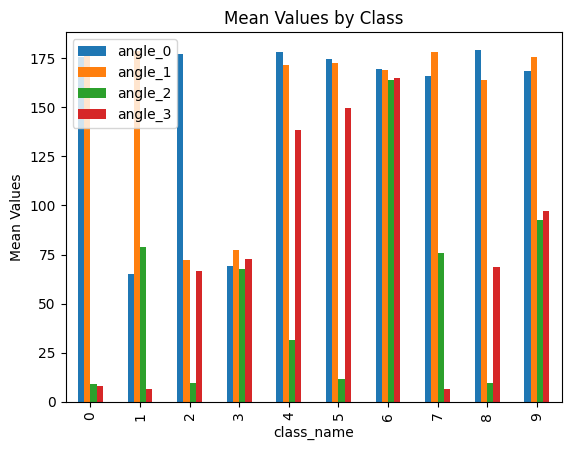

In [9]:
# Plot the mean values
mean_values.plot(kind='bar', ylabel='Mean Values', title='Mean Values by Class')

In [10]:
# Get number of data per each class

all_frames = os.listdir("frames/")
result = {}

for class_name in POSES:
    # Use a list comprehension to filter files that start with "0_"
    matching_files = [filename for filename in all_frames if filename.startswith(f"{class_name}_")]

    # Get the number of matching files
    number_of_matching_files = len(matching_files)
    result[class_name] = number_of_matching_files

print(result)


{'0': 2000, '1': 200, '2': 200, '3': 200, '4': 200, '5': 200, '6': 200, '7': 200, '8': 200, '9': 200, '10': 0, '11': 0, '12': 0}
